In [1]:
! nvidia-smi

Fri Aug  6 04:04:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = '..'
PATH = '/content/drive/MyDrive/Github/Ryles_Practice/'

In [4]:
!pip install konlpy

In [5]:
!cp '/content/drive/MyDrive/Github/Ryles_Practice/NLP/DL/preprocess.py' .

In [6]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'vla_' + string])
    plt.show()

In [8]:
DATA_IN_PATH = PATH+'DATA/data_in/'
DATA_OUT_PATH = PATH+'DATA/models/'
TRAIN_INPUTS = 'train_inputs.npy' # numpy 확장자 npy (구조 유지하는 binary 포맷)
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [9]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [10]:
import json
index_inputs = np.load(open(DATA_IN_PATH+TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH+TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH+TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH+DATA_CONFIG, 'r'))

In [11]:
MODEL_NAME = 'transformer_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCHS = 30
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']

# d-model: 단어의 차원, dff: feedforword 차원, num_head: 학습할 때 헤드(피쳐) 8개로
# maximum_position_encoding: 처음 입력 들어갈 때 해주는 위치 정보 인코딩

kargs = {'model_name':MODEL_NAME, 'num_layer':6, 'd-model':512, 'num_heads':8,
         'dff':2048, 'input_vocab_size':vocab_size, 'output_vocab_size':vocab_size,
         'maximum_position_encoding':MAX_SEQUENCE, 'end_token_idx':word2idx[eos_idx],
         'rate':0.1}

In [12]:
def create_padding_mask(seq):
    # seq 내의 내용이 pad인지 확인하여 pad 면 Ture(1), 아니면 False(0), 즉 마스킹하는 것
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :] # 모든 행에 대해, 새로운 차원, 새로운 차원, 모든 열에 대해 적용
    # 결과적으로 (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)

In [13]:
def create_look_ahead_mask(size):
    # tf.linalg.band_part? 주는 값에 따라 트라이앵글 형태로 바꿔서 가져옴
    # tf ~ 로 lower triangle 만들고 그걸 1에서 빼서 upper 부분을 마스킹하려는 것
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

---
1. tf.linalg.band_part(input, num_lower, num_upper, name=None)
2. band[i, j, k, ..., m, n] = in_band(m, n) * input[i, j, k, ..., m, n]
3. in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) && (num_upper < 0 || (n-m) <= num_upper)
---

In [14]:
def create_masks(input, target):
    enc_padding_mask = create_padding_mask(input)
    # decoder인데 왜 input? decoder 처음 input이 아니라 인코더 통해 받아서 더해주는 input에 대한 마스킹
    dec_padding_mask = create_padding_mask(input)
    # look_ahead_mask? decoding할 때 다음 단어의 attention 고려하지 않게 마스킹 하는 것
    # seq_len을 기준으로 마스킹 함
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)
    # 원래 마스킹 해야하는 부분과 어텐션할 때 마스킹 해야하는 부분 모두를 마스킹할 수 있도록 combine
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

\begin{align}
  PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})\\
  PE_{(pos,{2i+1})} = cos(pos/10000^{2i/d_{model}})
    \end{align}


In [16]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000,(2*i//2)/np.float(d_model))
    return pos*angle_rate

In [17]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


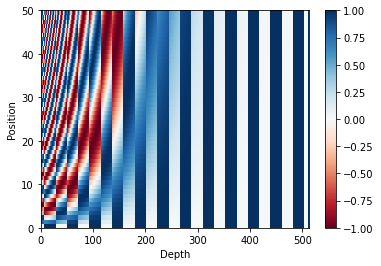

In [18]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim(0, 512)
plt.ylabel('Position')
plt.colorbar()
plt.show()

\begin{align}
  Attention(Q,K,V) = softmax(\frac{QK^t}{\sqrt{d_k}})V
    \end{align}

In [20]:
def scaled_dot_product_attention(q, k, v, mask):
    # transpose_a: a를 transpose / transpose_b: b를 tranpose -> k를 transpose 해줌
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    ## ** -> 언패킹(딕셔너리에 대해)
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_head = kargs['num_heads']
        self.d_model = kargs['d_model']

        # 이하 식이 조건에 맞는지 검사함. 검사해서 조건에 만족되면 멈춤
        assert self.d_model & self.num_heads == 0

        self.depth == self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.Dense(concat_attention)

        return output, attention_weight

In [ ]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)